Image colorization project :
We train a CNN to take in greyscale images of ... and output their colorful and plausible colorization.

Imports required :

torch

skimage ? only used for rgb - lab parsing. Maybe we can do that ourselves to make some differentiation with the original project?

numpy

matplotlib

PIL ? only used to open images to rgb. We can use another library

In [153]:
import matplotlib.pyplot as plt 
import numpy as np
from PIL import Image
#from skimage import color

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F

Load data, augment it, transform it to LAB compute stats on colors

In [154]:
#Data loading 

In [155]:
#LAB transform

[array([[[36.12643395, 74.7237478 ],
        [68.27200645, 57.15841288],
        [30.58742431,  7.87857414]],

       [[78.91004163,  6.35860304],
        [30.04847888, 22.25479969],
        [86.93046478, 58.48898759]],

       [[89.91140275, 79.43439784],
        [21.15828357, 92.47416693],
        [81.51745681, 44.85176954]]])]


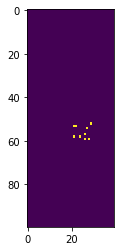

9
[(20, 90), (30, 10), (30, 20), (40, 70), (70, 60), (80, 10), (80, 40), (90, 60), (90, 80)]
[0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111]


In [156]:
#Color stats

# need dataset express like that: list of images (as tensor) with dim H x W x 2 ...
images = [np.random.rand(3,3,2) * 100]
print(images)

def getDiscretisedColor(a,b,gridSize):
    a = np.round(a/gridSize) * gridSize
    b = np.round(b/gridSize) * gridSize
    return (a,b)

def getMatrixIndex(a,b,gridSize):
    i = (a + 500) / gridSize
    j = (b + 200) / gridSize
    return (int(i),int(j))

def getColorValue(i,j,gridSize):
    a = i * gridSize - 500
    b = j * gridSize - 200
    return (a,b)

# Initiate the proba distribution of ab pairs in the images dataset (discretised).
gridSize = 10
colorProbabilities = np.zeros((1000 // gridSize, 400 // gridSize))

# Compute the proba distribution of the ab pairs in the images dataset (discretised).
nbOfAnalysedPixels = 0
for image in images:
    for h in range (image.shape[0]):
        for w in range (image.shape[1]):
            (a,b) = getDiscretisedColor(image[h][w][0],image[h][w][1],gridSize)
            (i,j) = getMatrixIndex(a,b,gridSize)
            colorProbabilities[i][j] += 1
            nbOfAnalysedPixels += 1
colorProbabilities = colorProbabilities / nbOfAnalysedPixels

# + display distribution in 2d plot ? like in paper (here, very simple)
plt.imshow(colorProbabilities, interpolation='none')
plt.show()

# Get the vector of proba of ab pairs that are "in gamut"
inGamutColors = []
inGamutColorsProbas = []
for i in range (colorProbabilities.shape[0]):
    for j in range (colorProbabilities.shape[1]):
        currentColorPorba = colorProbabilities[i][j]
        if currentColorPorba != 0:
            (a,b) = getColorValue(i,j,gridSize)
            inGamutColors.append((a,b))
            inGamutColorsProbas.append(currentColorPorba)
        
Q = len(inGamutColors) 
p = torch.tensor(inGamutColorsProbas)
print(Q)
print(inGamutColors)
print(inGamutColorsProbas)
Q = 1 # to remove


In [157]:
#Define pixel weight vector (class rebalancing)

# Set the parameters (from paper, need empirical value).
lambda_uniform = 1/2 
sigma = 5 # gaussian kernel parameter

# Compute a smooth version of the empirical pixel color distribution.
p_smooth = p # how to do that ? gaussian kernel ? to do

# Compute the weight vector.
pixelsWeights = torch.reciprocal((1 - lambda_uniform) * p_smooth + lambda_uniform / Q)

# Normalise the weight vector according to p_smooth (E[W] = 1).
E_W = torch.sum(p_smooth * pixelsWeights)
scale_factor = 1 / E_W
pixelsWeights = scale_factor * pixelsWeights 

Define and instantiate Convolutional NN consistent with the description of the paper. Shown in table 4.

In [158]:
#NN def

class ColorizationCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.l_cent = 50.
        self.l_norm = 100.
        self.ab_norm = 110.
        
        channels_block_1 = 64
        channels_block_2 = 128
        channels_block_3 = 256
        channels_block_4 = 512
        channels_block_5 = 512 #dilated
        channels_block_6 = 512 #dilated
        channels_block_7 = 512 
        channels_block_8 = 128 # transpose convolution necessary

        nb_colour_bins = 313
        # first conv block : 2 convs. from luminosity image to 64 features map from 3x3 kernels. 50% downsampling and normalization at the end.
        self.convBlock1 = nn.Sequential(nn.Conv2d(1,channels_block_1,(3,3), padding =1), 
                nn.ReLU(True), #inplace for memory efficiency can be used as no skip connections are used.
                nn.Conv2d(channels_block_1,channels_block_1,(3,3), padding =1,stride=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_1) #normalization over the 64 channels created
        )

        # second conv block. 2 covs. from 64 features to 128 features map from 3x3 kernels. 50% downsampling and normalization at the end.
        self.convBlock2 = nn.Sequential(nn.Conv2d(64,channels_block_2,(3,3), padding =1,), 
                nn.ReLU(True),
                nn.Conv2d(channels_block_2,channels_block_2,(3,3), padding =1,stride=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_2)
        )

        # third conv block. 3 convs. from 64 to 128 features map from 3x3 kernels. 50% downsampling and normalization at the end.
        self.convBlock3 = nn.Sequential(nn.Conv2d(channels_block_2,channels_block_3,(3,3), padding = 1,), 
                nn.ReLU(True),
                nn.Conv2d(channels_block_3,channels_block_3,(3,3), padding =1),
                nn.ReLU(True),
                nn.Conv2d(channels_block_3,channels_block_3,(3,3), padding =1,stride=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_3)
        )

        # fourth conv block. 3 convs. from 256 to 512 features map from 3x3 kernels. 50% downsampling and normalization at the end.
        self.convBlock4 = nn.Sequential(nn.Conv2d(channels_block_3,channels_block_4,(3,3), padding =1,),
                nn.ReLU(True),
                nn.Conv2d(channels_block_4,channels_block_4,(3,3), padding = 1),
                nn.ReLU(True),
                nn.Conv2d(channels_block_4,channels_block_4,(3,3), padding = 1), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_4)
        )
        
        #fifth conv block. 3 convs. no change in nb feature maps. 3x3 kernels with 2 dilation and 2 padding to not downscale. normalization at the end.

        self.convBlock5 = nn.Sequential(nn.Conv2d(channels_block_4,channels_block_5,(3,3),dilation=2,padding=2),
                nn.ReLU(True),
                nn.Conv2d(channels_block_5,channels_block_5,(3,3),dilation=2,padding=2),
                nn.ReLU(True),
                nn.Conv2d(channels_block_5,channels_block_5,(3,3),dilation=2,padding=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_5)
        )

        #sixth conv block. same as 5
        self.convBlock6 = nn.Sequential(nn.Conv2d(channels_block_5,channels_block_6,(3,3),dilation=2,padding=2),
                nn.ReLU(True),
                nn.Conv2d(channels_block_6,channels_block_6,(3,3),dilation=2,padding=2),
                nn.ReLU(True),
                nn.Conv2d(channels_block_6,channels_block_6,(3,3),dilation=2,padding=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_6)
        )

        #seventh conv block : 3 convs with 3x3 kernels.
        self.convBlock7 = nn.Sequential(nn.Conv2d(channels_block_6,channels_block_7,(3,3),padding =1,),
                nn.ReLU(True),
                nn.Conv2d(channels_block_7,channels_block_7,(3,3),padding =1,),
                nn.ReLU(True),
                nn.Conv2d(channels_block_7,channels_block_7,(3,3),padding =1,), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_7)
        )

        #eighth conv block : 1 inverse conv to upsample then 2 convs with 3x3 kernels default parameters. Final convolution with 1x1 for classification into a colour bin
        self.convBlock8 = nn.Sequential(nn.ConvTranspose2d(channels_block_7,channels_block_8,(4,4),stride = 2, padding =1),
                nn.ReLU(True),
                nn.Conv2d(channels_block_8,channels_block_8,(3,3),padding = 1),
                nn.ReLU(True),
                nn.Conv2d(channels_block_8,channels_block_8,(3,3),padding = 1), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.Conv2d(channels_block_8,nb_colour_bins,kernel_size=1) #1x1 kernel for classification in each colour bin (value will be soft maxed for probability)
        )

        self.outputLayer = nn.Conv2d(nb_colour_bins,2,kernel_size=1,dilation=1, bias = False) # 1x1 kernel to get 2 channel values of a and b respectively
    
    def forward(self, luminosity_image):
        h1 = self.convBlock1((luminosity_image-self.l_cent)/self.l_norm) #normalize luminosity to be on scale of 0 to 100
        h2 = self.convBlock2(h1)
        h3 = self.convBlock3(h2)
        h4 = self.convBlock4(h3)
        h5 = self.convBlock5(h4)
        h6 = self.convBlock6(h5)
        h7 = self.convBlock7(h6)
        h8 = self.convBlock8(h7)

        colour_bin_proba = (nn.Softmax(dim=1))(h8)
        output = self.outputLayer(colour_bin_proba)
        upscaled_output = (nn.Upsample(scale_factor=4, mode='bilinear'))(output) # bilinear upscale to agree with input image size 

        return upscaled_output * self.ab_norm # denormalize to cover whole ab value range
        
colCNN = ColorizationCNN()

Define optimizer

In [159]:
#ADAM
initial_lr = 3e-5
optimizer = torch.optim.Adam(colCNN.parameters(),lr = initial_lr , weight_decay=1e-3)
# lr will be decreased further when loss plateaus in the training loop. 

Define Loss

In [160]:
#Convert a true pixel Y to a distribution Z (soft encoding)

# to implement...
def getColorDistribution(Y):
    return 

In [161]:
#Convert a distribution Z to a true pixel Y (point estimate)

# to implement...
def getColorEstimate(Z):
    return 

In [162]:
#v(Z_hw) weight in paper (section 2)

def getPixelsWeights(Z):
    W = torch.argmax(Z, dim=2)
    for i in range(W.size(dim=0)):
        for j in range(W.size(dim=1)):
            W[i,j] = pixelsWeights(W[i,j])

    return W

In [163]:
#loss function 

def multinomialCrossEntropyLoss(Z_estimate, Z):
    W = getPixelsWeights(Z)
    L = - sum(W * torch.sum(Z * torch.log10(Z_estimate), dim=2))

    return L

Define a trining step: prediction, loss, backprop loss

In [ ]:
def training_step(optim,loss_fct,network,dataloader):

    iteration_losses = []

    for image in dataloader:

        predicted_colour_probability = network.forward(image)
        loss = loss_fct(predicted_colour_probability,getColorDistribution(data))
        iteration_losses.append(loss.item())

        optim.zero_grad() 
        loss.backward()
        optim.step()

    return sum(iteration_losses) / len(iteration_losses) # average loss of training iteration

Main training loop and additional function TBD

In [ ]:
nb_steps = 1000
losses = np.zeros(nb_steps)

imageLoader = torch.utils.data.DataLoader( dataset , batch_size=100, shuffle=True, num_workers=2)

for step in range(nb_steps):
    print('step :',step,end='\r')
    losses[step] = training_step(optimizer,multinomialCrossEntropyLoss,colCNN,imageLoader)


Plot losses

In [ ]:
x_axis = range(1,nb_steps)
plt.plot(x_axis,losses, label="train loss")

plt.xlabel('number of training steps')
plt.ylabel('avg loss')
plt.title('multinomial cross entropy loss')
plt.legend()
plt.show()

Show the neural network colorization of a specific image vs the real colors of that image